# Set-Up

Installations and imports:

In [79]:
import os
from math import ceil
from numpyencoder import NumpyEncoder
import time
import json
import numpy as np
import sys
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import fenics_helpers

Plotting settings:

In [80]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
mpl.rcParams['figure.dpi'] = 100
mpl_save_dpi = 300

Save settings:

In [3]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)
data_save_dir = './data'
if not os.path.isdir(data_save_dir):
    os.mkdir(data_save_dir)

Directory of breast mesh:

In [4]:
BREAST_DIR = './breast_closed.obj'

Define parameters which never change between simulations:

In [60]:
always_fixed_params = {# Physical parameters:
                       'density': 0.00102, # in g/mm^3
                       'g': 9.81, # in m/s^3
                       'elem_order': 2,
                       # Non-linear solver parameters:
                       'num_load_steps': 50, 
                       'rtol': 1e-9, 
                       'atol': 1e-9, 
                       'max_iter': 50,
                       'kappa': 3000, # in kPa   
                       'x_to_fix': 10} 

# Train Data Simulations

In [66]:
fixed_params = {'C_1': 0.5, # in kPa
                'z_rot': 90, # in degrees
                'y_rot': 90, # in degrees
                **always_fixed_params}

# Vary number of surface points on mesh:
num_surfpts_list = list(range(40, 170, 20))

results = {key: [] for key in ('tip_disp', 'max_disp', 'num_surfpts', 'num_elem', 'volume')}
for i, num_surfpts in enumerate(num_surfpts_list):
    
    mesh = fenics_helpers.create_breast_mesh(BREAST_DIR, num_surfpts)
    num_elem = mesh.geometry.dofmap.array.shape[0]
    
    print(f"Simulating Mesh {i+1}/{len(num_surfpts_list)} (Num Surf Pts={num_surfpts}, Num elem = {num_elem})")
    
    u = fenics_helpers.simulate_neohookean_breast(mesh, **fixed_params)
    
    u_def = fenics_helpers.compute_deformation(u, mesh)
    disp = np.sqrt(np.sum(u_def**2, axis=1))
    tip_idx = np.argmax(mesh.geometry.x[:,0])
    tip_disp = disp[tip_idx]
    max_disp = np.max(disp)
    
    vols = fenics_helpers.compute_pre_and_postdeformation_volume(u, mesh)
    
    print(f'Tip disp = {tip_disp}, Max disp = {max_disp},  Volumes = {vols}\n')
    
    results['tip_disp'].append(tip_disp)
    results['max_disp'].append(max_disp)
    results['volume'].append(vols)
    results['num_surfpts'].append(num_surfpts)
    results['num_elem'].append(num_elem)
    
results['fixed_params'] = fixed_params

with open(os.path.join(data_save_dir, 'neohookean_breast_meshsize_convergence.json'), 'w') as f:
    json.dump(results, f, indent=4, cls=NumpyEncoder)

Simulating Mesh 1/7 (Num Surf Pts=40, Num elem = 2752)
Performing load step 1/50...
Performing load step 2/50...
Performing load step 3/50...
Performing load step 4/50...
Performing load step 5/50...
Performing load step 6/50...
Performing load step 7/50...
Performing load step 8/50...
Performing load step 9/50...
Performing load step 10/50...
Performing load step 11/50...
Performing load step 12/50...
Performing load step 13/50...
Performing load step 14/50...
Performing load step 15/50...
Performing load step 16/50...
Performing load step 17/50...
Performing load step 18/50...
Performing load step 19/50...
Performing load step 20/50...
Performing load step 21/50...
Performing load step 22/50...
Performing load step 23/50...
Performing load step 24/50...
Performing load step 25/50...
Performing load step 26/50...
Performing load step 27/50...
Performing load step 28/50...
Performing load step 29/50...
Performing load step 30/50...
Performing load step 31/50...
Performing load step 32/

Let's now plot these results:

In [72]:
with open(os.path.join(data_save_dir, 'neohookean_breast_meshsize_convergence.json'), 'r') as f:
    results = json.load(f)

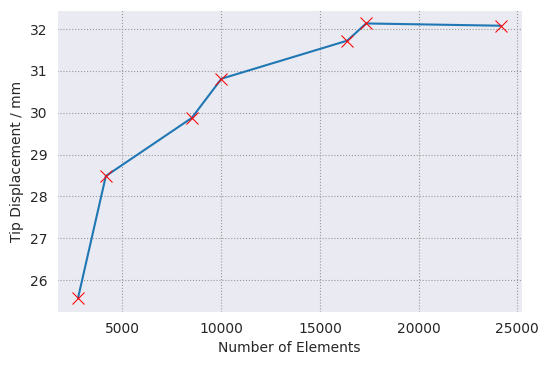

In [88]:
ax = sns.lineplot(x=results['num_elem'], y=results['tip_disp'], marker='x', markersize=8, mec='r')
ax.set(xlabel='Number of Elements', ylabel='Tip Displacement / mm')
plt.show()

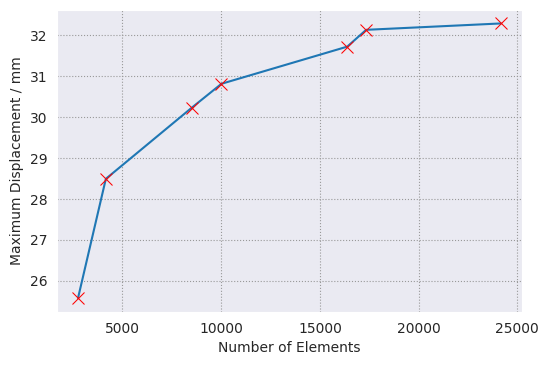

In [85]:
ax = sns.lineplot(x=results['num_elem'], y=results['max_disp'], marker='x', markersize=8, mec='r')
ax.set(xlabel='Number of Elements', ylabel='Maximum Displacement / mm')
plt.show()

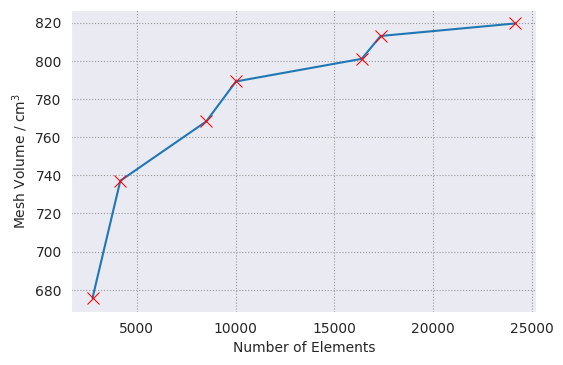

In [86]:
vol_in_cm3 = np.array(results['volume'])[:,0]/10**3
ax = sns.lineplot(x=results['num_elem'], y=vol_in_cm3, marker='x', markersize=8, mec='r')
ax.set(xlabel='Number of Elements', ylabel='Mesh Volume / cm$^3$')
plt.show()

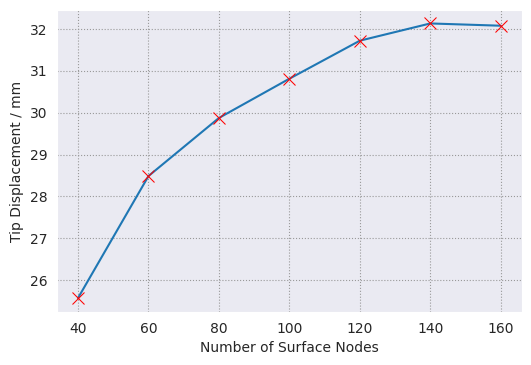

In [89]:
ax = sns.lineplot(x=results['num_surfpts'], y=results['tip_disp'], marker='x', markersize=8, mec='r')
ax.set(xlabel='Number of Surface Nodes', ylabel='Tip Displacement / mm')
plt.show()

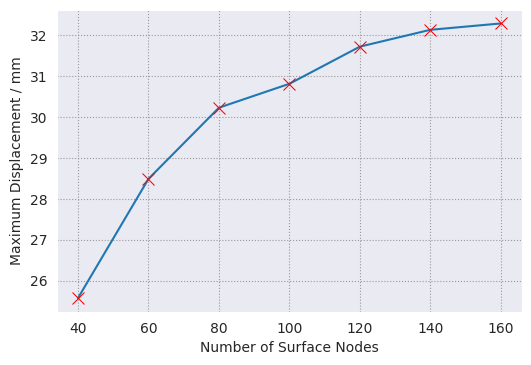

In [90]:
ax = sns.lineplot(x=results['num_surfpts'], y=results['max_disp'], marker='x', markersize=8, mec='r')
ax.set(xlabel='Number of Surface Nodes', ylabel='Maximum Displacement / mm')
plt.show()

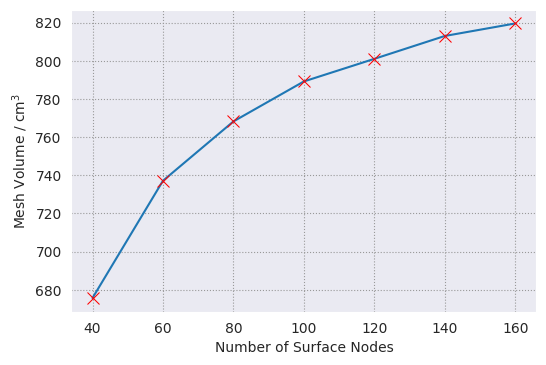

In [92]:
vol_in_cm3 = np.array(results['volume'])[:,0]/10**3
ax = sns.lineplot(x=results['num_surfpts'], y=vol_in_cm3, marker='x', markersize=8, mec='r')
ax.set(xlabel='Number of Surface Nodes', ylabel='Mesh Volume / cm$^3$')
plt.show()